# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

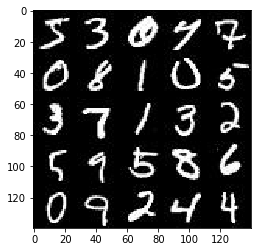

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

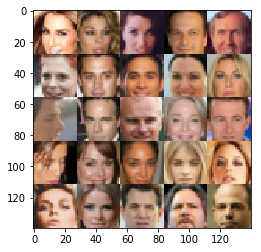

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


D:\Program Files (x86)\anaconda\envs\face_generation\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(shape=[None,image_width,image_height,image_channels],dtype=tf.float32,name='input_real')
    inputs_z=tf.placeholder(shape=[None,z_dim],dtype=tf.float32,name='input_z')
    learning_rate=tf.placeholder(dtype=tf.float32,name='lr',shape=())
    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #conv1
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.maximum(x1,0.2*x1)
        x1=tf.nn.dropout(x1,0.8)
        #14*14*64
        
        #conv2
        x2=tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=True)
        x2=tf.maximum(x2,0.2*x2)
        x2=tf.nn.dropout(x2,0.8)
        #7*7*128
        
        #conv3
        x3=tf.layers.conv2d(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())#4*4*256
        logits=tf.layers.dense(tf.reshape(x3,(-1,4*4*256)),1) #fully-connected
        output=tf.nn.sigmoid(logits)
        
    return  output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse=not is_train
    with tf.variable_scope('generator',reuse=reuse):
        
        x1=tf.layers.dense(z,(7*7*512))
        x1=tf.reshape(x1,(-1,7,7,512))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(x1,0.2*x1)
        x1=tf.nn.dropout(x1,0.8)
        #7*7*512
        
        #conv1
        x2=tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(x2,0.2*x2)
        x2=tf.nn.dropout(x2,0.8)
        #14*14*256
        
        
        #conv2
        logits=tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        output=0.5*tf.tanh(logits)
        #28*28*out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim)
    d_real_output,d_real_logits=discriminator(input_real)
    d_fake_output,d_fake_logits=discriminator(g_model,True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_output)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_output)))
    d_loss=d_loss_real+d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_output)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    inputs_real,inputs_z,lr=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z,data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d,train_loss_g = d_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate}) ,g_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                    print("Epoch {}/{}...".format(steps, epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, inputs_z, data_shape[3], data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 10/0... Discriminator Loss: 0.6972... Generator Loss: 3.4300
Epoch 20/0... Discriminator Loss: 8.7718... Generator Loss: 0.0080
Epoch 30/0... Discriminator Loss: 4.1120... Generator Loss: 0.0678
Epoch 40/0... Discriminator Loss: 2.6936... Generator Loss: 0.2490
Epoch 50/0... Discriminator Loss: 1.8268... Generator Loss: 0.7741
Epoch 60/0... Discriminator Loss: 2.2847... Generator Loss: 0.4188
Epoch 70/0... Discriminator Loss: 2.5631... Generator Loss: 0.2147
Epoch 80/0... Discriminator Loss: 1.8862... Generator Loss: 0.4457
Epoch 90/0... Discriminator Loss: 2.2597... Generator Loss: 0.3586
Epoch 100/0... Discriminator Loss: 1.8664... Generator Loss: 0.5144


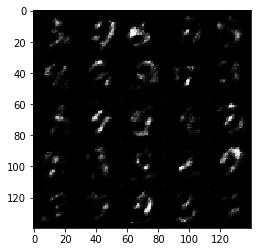

Epoch 110/0... Discriminator Loss: 1.9973... Generator Loss: 0.5366
Epoch 120/0... Discriminator Loss: 1.7966... Generator Loss: 0.4231
Epoch 130/0... Discriminator Loss: 1.7813... Generator Loss: 0.4745
Epoch 140/0... Discriminator Loss: 2.1138... Generator Loss: 0.3958
Epoch 150/0... Discriminator Loss: 1.7015... Generator Loss: 0.5827
Epoch 160/0... Discriminator Loss: 1.5971... Generator Loss: 0.5625
Epoch 170/0... Discriminator Loss: 1.6832... Generator Loss: 0.4394
Epoch 180/0... Discriminator Loss: 1.6604... Generator Loss: 0.5406
Epoch 190/0... Discriminator Loss: 1.5617... Generator Loss: 0.5379
Epoch 200/0... Discriminator Loss: 1.6490... Generator Loss: 0.5808


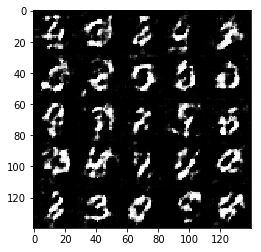

Epoch 210/0... Discriminator Loss: 1.8733... Generator Loss: 0.6860
Epoch 220/0... Discriminator Loss: 1.4613... Generator Loss: 0.8256
Epoch 230/0... Discriminator Loss: 1.8066... Generator Loss: 0.7257
Epoch 240/0... Discriminator Loss: 1.6625... Generator Loss: 0.3910
Epoch 250/0... Discriminator Loss: 1.4988... Generator Loss: 0.7491
Epoch 260/0... Discriminator Loss: 1.3719... Generator Loss: 0.6909
Epoch 270/0... Discriminator Loss: 1.5652... Generator Loss: 0.5024
Epoch 280/0... Discriminator Loss: 1.5735... Generator Loss: 0.7691
Epoch 290/0... Discriminator Loss: 1.6363... Generator Loss: 0.6491
Epoch 300/0... Discriminator Loss: 1.5789... Generator Loss: 0.4051


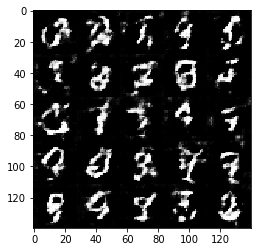

Epoch 310/0... Discriminator Loss: 1.5117... Generator Loss: 0.7531
Epoch 320/0... Discriminator Loss: 1.5189... Generator Loss: 0.5769
Epoch 330/0... Discriminator Loss: 1.5508... Generator Loss: 0.5264
Epoch 340/0... Discriminator Loss: 1.5845... Generator Loss: 0.5090
Epoch 350/0... Discriminator Loss: 1.5608... Generator Loss: 0.8787
Epoch 360/0... Discriminator Loss: 1.5982... Generator Loss: 0.4700
Epoch 370/0... Discriminator Loss: 1.4573... Generator Loss: 0.5337
Epoch 380/0... Discriminator Loss: 1.4844... Generator Loss: 0.5597
Epoch 390/0... Discriminator Loss: 1.4151... Generator Loss: 0.8833
Epoch 400/0... Discriminator Loss: 1.5876... Generator Loss: 0.3959


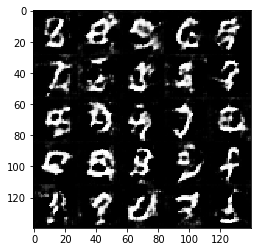

Epoch 410/0... Discriminator Loss: 1.4427... Generator Loss: 0.8842
Epoch 420/0... Discriminator Loss: 1.3655... Generator Loss: 0.8140


KeyboardInterrupt: 

In [12]:
batch_size =32 #None
z_dim =128 #None
learning_rate =0.001 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 10/0... Discriminator Loss: 2.9769... Generator Loss: 0.5475
Epoch 20/0... Discriminator Loss: 4.3627... Generator Loss: 0.0619
Epoch 30/0... Discriminator Loss: 1.7982... Generator Loss: 7.2087
Epoch 40/0... Discriminator Loss: 1.7693... Generator Loss: 4.5799
Epoch 50/0... Discriminator Loss: 2.8501... Generator Loss: 6.5693
Epoch 60/0... Discriminator Loss: 3.3799... Generator Loss: 0.0808
Epoch 70/0... Discriminator Loss: 2.0451... Generator Loss: 0.2428
Epoch 80/0... Discriminator Loss: 1.9163... Generator Loss: 0.2644
Epoch 90/0... Discriminator Loss: 2.1872... Generator Loss: 0.2602
Epoch 100/0... Discriminator Loss: 1.7513... Generator Loss: 0.3551


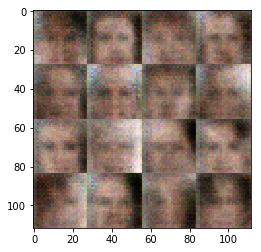

Epoch 110/0... Discriminator Loss: 1.2063... Generator Loss: 1.4293
Epoch 120/0... Discriminator Loss: 1.3768... Generator Loss: 0.6988
Epoch 130/0... Discriminator Loss: 1.6485... Generator Loss: 0.3824
Epoch 140/0... Discriminator Loss: 1.4396... Generator Loss: 0.4779
Epoch 150/0... Discriminator Loss: 1.6953... Generator Loss: 0.4645
Epoch 160/0... Discriminator Loss: 1.4438... Generator Loss: 0.6537
Epoch 170/0... Discriminator Loss: 1.4667... Generator Loss: 0.6036
Epoch 180/0... Discriminator Loss: 1.7391... Generator Loss: 0.4600
Epoch 190/0... Discriminator Loss: 1.7480... Generator Loss: 0.3795
Epoch 200/0... Discriminator Loss: 1.4135... Generator Loss: 0.5966


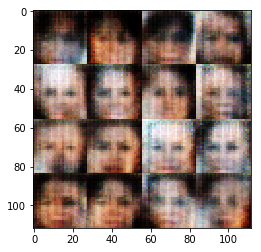

Epoch 210/0... Discriminator Loss: 1.0912... Generator Loss: 2.9674
Epoch 220/0... Discriminator Loss: 1.3048... Generator Loss: 0.7250
Epoch 230/0... Discriminator Loss: 0.9043... Generator Loss: 2.7671
Epoch 240/0... Discriminator Loss: 1.5480... Generator Loss: 0.5526
Epoch 250/0... Discriminator Loss: 1.4039... Generator Loss: 1.8000
Epoch 260/0... Discriminator Loss: 1.6813... Generator Loss: 0.4628
Epoch 270/0... Discriminator Loss: 1.2812... Generator Loss: 0.6204
Epoch 280/0... Discriminator Loss: 1.3711... Generator Loss: 0.8235
Epoch 290/0... Discriminator Loss: 1.4038... Generator Loss: 0.6335
Epoch 300/0... Discriminator Loss: 1.3881... Generator Loss: 0.7085


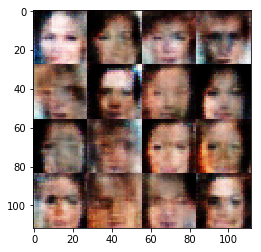

Epoch 310/0... Discriminator Loss: 1.5096... Generator Loss: 0.5018
Epoch 320/0... Discriminator Loss: 1.4757... Generator Loss: 0.5107
Epoch 330/0... Discriminator Loss: 1.3710... Generator Loss: 0.6715
Epoch 340/0... Discriminator Loss: 1.5603... Generator Loss: 0.7557
Epoch 350/0... Discriminator Loss: 1.4506... Generator Loss: 0.7866
Epoch 360/0... Discriminator Loss: 1.3604... Generator Loss: 0.6726
Epoch 370/0... Discriminator Loss: 1.5370... Generator Loss: 0.7221
Epoch 380/0... Discriminator Loss: 1.4420... Generator Loss: 0.5680
Epoch 390/0... Discriminator Loss: 1.5401... Generator Loss: 0.9135
Epoch 400/0... Discriminator Loss: 1.5580... Generator Loss: 0.5755


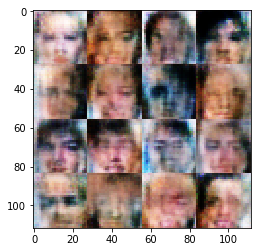

Epoch 410/0... Discriminator Loss: 1.5962... Generator Loss: 0.6486
Epoch 420/0... Discriminator Loss: 1.1214... Generator Loss: 1.3701
Epoch 430/0... Discriminator Loss: 1.5940... Generator Loss: 0.3368
Epoch 440/0... Discriminator Loss: 1.6508... Generator Loss: 0.4249
Epoch 450/0... Discriminator Loss: 1.4818... Generator Loss: 0.7127
Epoch 460/0... Discriminator Loss: 1.5919... Generator Loss: 0.5477
Epoch 470/0... Discriminator Loss: 1.5728... Generator Loss: 0.7223
Epoch 480/0... Discriminator Loss: 1.5325... Generator Loss: 0.6477
Epoch 490/0... Discriminator Loss: 1.5575... Generator Loss: 1.0266
Epoch 500/0... Discriminator Loss: 1.5325... Generator Loss: 0.7545


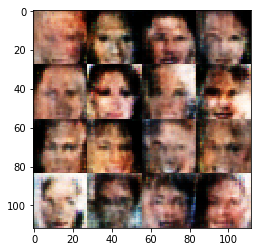

Epoch 510/0... Discriminator Loss: 1.2998... Generator Loss: 0.7943
Epoch 520/0... Discriminator Loss: 1.3861... Generator Loss: 0.7220
Epoch 530/0... Discriminator Loss: 1.2786... Generator Loss: 0.7403
Epoch 540/0... Discriminator Loss: 1.3899... Generator Loss: 0.7741
Epoch 550/0... Discriminator Loss: 1.2510... Generator Loss: 0.7928
Epoch 560/0... Discriminator Loss: 1.2725... Generator Loss: 0.6140
Epoch 570/0... Discriminator Loss: 1.5016... Generator Loss: 0.6126
Epoch 580/0... Discriminator Loss: 1.0449... Generator Loss: 0.9375
Epoch 590/0... Discriminator Loss: 1.3744... Generator Loss: 0.6918
Epoch 600/0... Discriminator Loss: 1.1117... Generator Loss: 0.9718


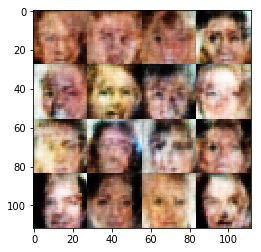

Epoch 610/0... Discriminator Loss: 1.0623... Generator Loss: 1.3192
Epoch 620/0... Discriminator Loss: 1.4193... Generator Loss: 0.5203
Epoch 630/0... Discriminator Loss: 1.6056... Generator Loss: 0.3852
Epoch 640/0... Discriminator Loss: 1.2329... Generator Loss: 0.9194
Epoch 650/0... Discriminator Loss: 1.3977... Generator Loss: 0.7023
Epoch 660/0... Discriminator Loss: 1.3337... Generator Loss: 0.7711
Epoch 670/0... Discriminator Loss: 1.3949... Generator Loss: 0.7219
Epoch 680/0... Discriminator Loss: 1.5037... Generator Loss: 0.6078
Epoch 690/0... Discriminator Loss: 1.5163... Generator Loss: 0.5858
Epoch 700/0... Discriminator Loss: 1.4490... Generator Loss: 0.6362


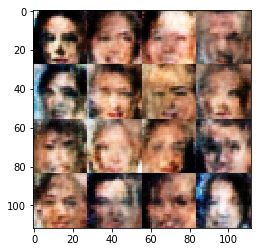

Epoch 710/0... Discriminator Loss: 1.4346... Generator Loss: 0.7178
Epoch 720/0... Discriminator Loss: 1.5062... Generator Loss: 0.7049
Epoch 730/0... Discriminator Loss: 1.3123... Generator Loss: 0.7271
Epoch 740/0... Discriminator Loss: 1.4264... Generator Loss: 0.6820
Epoch 750/0... Discriminator Loss: 1.4182... Generator Loss: 0.8550
Epoch 760/0... Discriminator Loss: 1.4101... Generator Loss: 0.6867
Epoch 770/0... Discriminator Loss: 1.4800... Generator Loss: 0.6577
Epoch 780/0... Discriminator Loss: 1.4052... Generator Loss: 0.5846
Epoch 790/0... Discriminator Loss: 1.4115... Generator Loss: 0.6528
Epoch 800/0... Discriminator Loss: 1.4572... Generator Loss: 0.7175


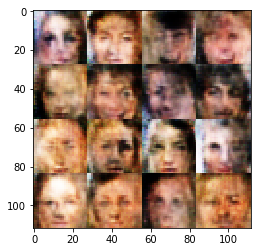

Epoch 810/0... Discriminator Loss: 1.5024... Generator Loss: 0.5223
Epoch 820/0... Discriminator Loss: 1.5239... Generator Loss: 0.6325
Epoch 830/0... Discriminator Loss: 1.3472... Generator Loss: 0.7253
Epoch 840/0... Discriminator Loss: 1.2187... Generator Loss: 1.0297
Epoch 850/0... Discriminator Loss: 1.4747... Generator Loss: 0.8193
Epoch 860/0... Discriminator Loss: 1.3221... Generator Loss: 0.8628
Epoch 870/0... Discriminator Loss: 1.3752... Generator Loss: 0.8441
Epoch 880/0... Discriminator Loss: 1.3595... Generator Loss: 0.7399
Epoch 890/0... Discriminator Loss: 1.3996... Generator Loss: 0.7131
Epoch 900/0... Discriminator Loss: 1.4213... Generator Loss: 0.7022


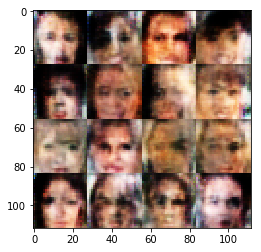

Epoch 910/0... Discriminator Loss: 1.4510... Generator Loss: 0.7344
Epoch 920/0... Discriminator Loss: 1.4108... Generator Loss: 0.6797
Epoch 930/0... Discriminator Loss: 1.5184... Generator Loss: 0.6897
Epoch 940/0... Discriminator Loss: 1.3452... Generator Loss: 0.7663
Epoch 950/0... Discriminator Loss: 1.2125... Generator Loss: 0.9359
Epoch 960/0... Discriminator Loss: 1.2126... Generator Loss: 1.0528
Epoch 970/0... Discriminator Loss: 4.5691... Generator Loss: 3.0782
Epoch 980/0... Discriminator Loss: 1.6867... Generator Loss: 0.5164
Epoch 990/0... Discriminator Loss: 2.0654... Generator Loss: 0.3356
Epoch 1000/0... Discriminator Loss: 1.3758... Generator Loss: 0.8055


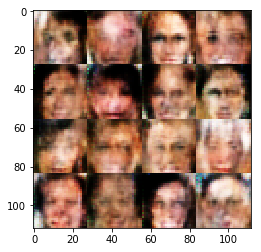

Epoch 1010/0... Discriminator Loss: 1.4314... Generator Loss: 0.7451
Epoch 1020/0... Discriminator Loss: 1.3563... Generator Loss: 0.7178
Epoch 1030/0... Discriminator Loss: 1.4735... Generator Loss: 0.5672
Epoch 1040/0... Discriminator Loss: 1.3154... Generator Loss: 0.7328
Epoch 1050/0... Discriminator Loss: 1.4204... Generator Loss: 0.7402
Epoch 1060/0... Discriminator Loss: 1.4114... Generator Loss: 0.7250
Epoch 1070/0... Discriminator Loss: 1.4275... Generator Loss: 0.7068
Epoch 1080/0... Discriminator Loss: 1.3463... Generator Loss: 0.7011
Epoch 1090/0... Discriminator Loss: 1.3398... Generator Loss: 0.6868
Epoch 1100/0... Discriminator Loss: 1.2092... Generator Loss: 1.0533


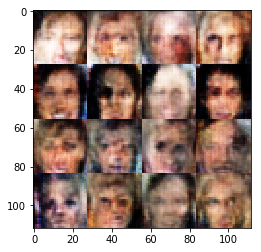

Epoch 1110/0... Discriminator Loss: 1.4237... Generator Loss: 0.8771
Epoch 1120/0... Discriminator Loss: 1.5580... Generator Loss: 0.5705
Epoch 1130/0... Discriminator Loss: 1.3501... Generator Loss: 0.8314
Epoch 1140/0... Discriminator Loss: 1.1280... Generator Loss: 0.9691
Epoch 1150/0... Discriminator Loss: 1.6471... Generator Loss: 0.5918
Epoch 1160/0... Discriminator Loss: 1.3051... Generator Loss: 0.7753
Epoch 1170/0... Discriminator Loss: 1.4084... Generator Loss: 0.7057
Epoch 1180/0... Discriminator Loss: 1.3230... Generator Loss: 0.8604
Epoch 1190/0... Discriminator Loss: 1.3031... Generator Loss: 0.8057
Epoch 1200/0... Discriminator Loss: 1.4945... Generator Loss: 0.6963


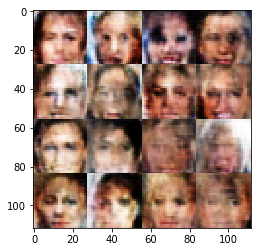

Epoch 1210/0... Discriminator Loss: 1.4902... Generator Loss: 0.7224
Epoch 1220/0... Discriminator Loss: 1.4136... Generator Loss: 0.6713
Epoch 1230/0... Discriminator Loss: 1.3883... Generator Loss: 0.8107
Epoch 1240/0... Discriminator Loss: 1.3033... Generator Loss: 0.8035
Epoch 1250/0... Discriminator Loss: 1.4339... Generator Loss: 0.8371
Epoch 1260/0... Discriminator Loss: 1.3071... Generator Loss: 0.7711
Epoch 1270/0... Discriminator Loss: 1.3859... Generator Loss: 0.7907
Epoch 1280/0... Discriminator Loss: 1.3010... Generator Loss: 0.7358
Epoch 1290/0... Discriminator Loss: 1.4149... Generator Loss: 0.7259
Epoch 1300/0... Discriminator Loss: 0.8547... Generator Loss: 3.9399


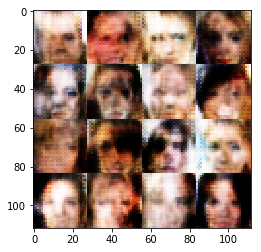

Epoch 1310/0... Discriminator Loss: 21.5344... Generator Loss: 2.1911
Epoch 1320/0... Discriminator Loss: 1.2376... Generator Loss: 0.7819
Epoch 1330/0... Discriminator Loss: 1.4609... Generator Loss: 1.0687
Epoch 1340/0... Discriminator Loss: 1.2850... Generator Loss: 0.7667
Epoch 1350/0... Discriminator Loss: 1.4451... Generator Loss: 0.6898
Epoch 1360/0... Discriminator Loss: 1.4464... Generator Loss: 0.7502
Epoch 1370/0... Discriminator Loss: 1.3226... Generator Loss: 0.6808
Epoch 1380/0... Discriminator Loss: 1.3171... Generator Loss: 0.8148
Epoch 1390/0... Discriminator Loss: 1.4018... Generator Loss: 0.7327
Epoch 1400/0... Discriminator Loss: 1.3476... Generator Loss: 0.7566


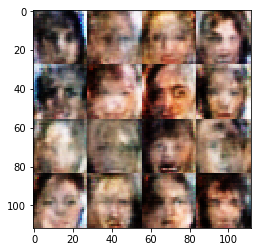

Epoch 1410/0... Discriminator Loss: 1.3514... Generator Loss: 0.9343
Epoch 1420/0... Discriminator Loss: 1.2951... Generator Loss: 0.7307
Epoch 1430/0... Discriminator Loss: 1.3873... Generator Loss: 0.7284
Epoch 1440/0... Discriminator Loss: 1.2667... Generator Loss: 0.7750
Epoch 1450/0... Discriminator Loss: 1.4582... Generator Loss: 0.7471
Epoch 1460/0... Discriminator Loss: 1.3594... Generator Loss: 0.7208
Epoch 1470/0... Discriminator Loss: 1.4837... Generator Loss: 0.7518
Epoch 1480/0... Discriminator Loss: 1.4623... Generator Loss: 0.7058
Epoch 1490/0... Discriminator Loss: 1.3804... Generator Loss: 0.7553
Epoch 1500/0... Discriminator Loss: 1.3646... Generator Loss: 0.6967


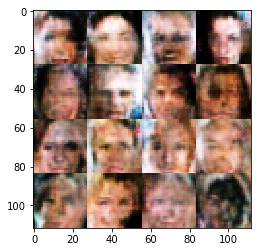

Epoch 1510/0... Discriminator Loss: 1.6830... Generator Loss: 0.6965
Epoch 1520/0... Discriminator Loss: 1.4239... Generator Loss: 0.9545
Epoch 1530/0... Discriminator Loss: 1.1547... Generator Loss: 1.2216
Epoch 1540/0... Discriminator Loss: 1.3842... Generator Loss: 0.7560
Epoch 1550/0... Discriminator Loss: 1.3312... Generator Loss: 0.9166
Epoch 1560/0... Discriminator Loss: 1.4000... Generator Loss: 0.7697
Epoch 1570/0... Discriminator Loss: 1.3031... Generator Loss: 0.8085
Epoch 1580/0... Discriminator Loss: 1.4271... Generator Loss: 0.7728
Epoch 1590/0... Discriminator Loss: 1.3001... Generator Loss: 0.8232
Epoch 1600/0... Discriminator Loss: 1.2052... Generator Loss: 0.7833


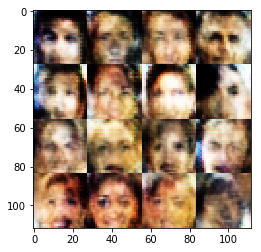

Epoch 1610/0... Discriminator Loss: 1.4610... Generator Loss: 0.8245
Epoch 1620/0... Discriminator Loss: 1.3393... Generator Loss: 0.7520
Epoch 1630/0... Discriminator Loss: 1.3808... Generator Loss: 0.7975
Epoch 1640/0... Discriminator Loss: 1.4216... Generator Loss: 0.7279
Epoch 1650/0... Discriminator Loss: 1.4052... Generator Loss: 0.6777
Epoch 1660/0... Discriminator Loss: 1.3733... Generator Loss: 0.7254
Epoch 1670/0... Discriminator Loss: 1.4888... Generator Loss: 0.7783
Epoch 1680/0... Discriminator Loss: 1.3183... Generator Loss: 0.7857
Epoch 1690/0... Discriminator Loss: 1.2432... Generator Loss: 0.8578
Epoch 1700/0... Discriminator Loss: 1.3085... Generator Loss: 1.0797


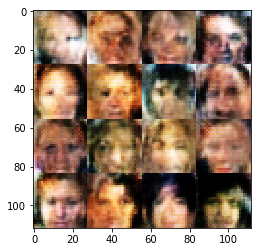

Epoch 1710/0... Discriminator Loss: 1.3595... Generator Loss: 0.7045
Epoch 1720/0... Discriminator Loss: 1.3177... Generator Loss: 0.8198
Epoch 1730/0... Discriminator Loss: 1.5861... Generator Loss: 0.6077
Epoch 1740/0... Discriminator Loss: 1.2704... Generator Loss: 1.2198
Epoch 1750/0... Discriminator Loss: 1.2116... Generator Loss: 1.4538
Epoch 1760/0... Discriminator Loss: 1.2473... Generator Loss: 3.4275
Epoch 1770/0... Discriminator Loss: 1.8467... Generator Loss: 0.5367
Epoch 1780/0... Discriminator Loss: 1.3098... Generator Loss: 0.8974
Epoch 1790/0... Discriminator Loss: 1.4253... Generator Loss: 0.8092
Epoch 1800/0... Discriminator Loss: 1.4084... Generator Loss: 0.8144


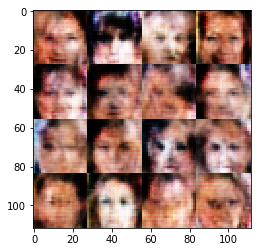

Epoch 1810/0... Discriminator Loss: 1.4851... Generator Loss: 0.7908
Epoch 1820/0... Discriminator Loss: 1.5177... Generator Loss: 0.6953
Epoch 1830/0... Discriminator Loss: 1.3952... Generator Loss: 0.6833
Epoch 1840/0... Discriminator Loss: 1.3450... Generator Loss: 0.8159
Epoch 1850/0... Discriminator Loss: 1.3916... Generator Loss: 0.8087
Epoch 1860/0... Discriminator Loss: 1.4467... Generator Loss: 0.8514
Epoch 1870/0... Discriminator Loss: 1.4631... Generator Loss: 0.6670
Epoch 1880/0... Discriminator Loss: 1.4215... Generator Loss: 0.7426
Epoch 1890/0... Discriminator Loss: 1.3913... Generator Loss: 0.7552
Epoch 1900/0... Discriminator Loss: 1.3930... Generator Loss: 0.7631


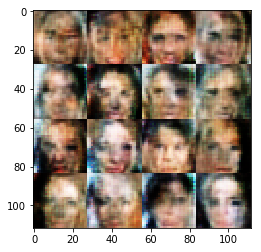

Epoch 1910/0... Discriminator Loss: 1.4531... Generator Loss: 0.7250
Epoch 1920/0... Discriminator Loss: 1.3244... Generator Loss: 0.8232
Epoch 1930/0... Discriminator Loss: 1.3859... Generator Loss: 0.7912
Epoch 1940/0... Discriminator Loss: 1.4687... Generator Loss: 0.6384
Epoch 1950/0... Discriminator Loss: 1.3563... Generator Loss: 0.6539
Epoch 1960/0... Discriminator Loss: 1.4393... Generator Loss: 0.6855
Epoch 1970/0... Discriminator Loss: 1.3783... Generator Loss: 0.7615
Epoch 1980/0... Discriminator Loss: 1.3628... Generator Loss: 0.7021
Epoch 1990/0... Discriminator Loss: 1.3913... Generator Loss: 0.7655
Epoch 2000/0... Discriminator Loss: 1.4286... Generator Loss: 0.6736


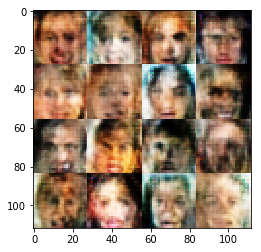

Epoch 2010/0... Discriminator Loss: 1.4122... Generator Loss: 0.6879
Epoch 2020/0... Discriminator Loss: 1.4245... Generator Loss: 0.7581
Epoch 2030/0... Discriminator Loss: 1.4060... Generator Loss: 0.6279
Epoch 2040/0... Discriminator Loss: 1.4849... Generator Loss: 0.6419
Epoch 2050/0... Discriminator Loss: 1.4064... Generator Loss: 0.8250
Epoch 2060/0... Discriminator Loss: 1.3066... Generator Loss: 0.8845
Epoch 2070/0... Discriminator Loss: 1.3084... Generator Loss: 0.8147
Epoch 2080/0... Discriminator Loss: 1.3078... Generator Loss: 0.7336
Epoch 2090/0... Discriminator Loss: 1.3373... Generator Loss: 0.6682
Epoch 2100/0... Discriminator Loss: 1.3408... Generator Loss: 0.7360


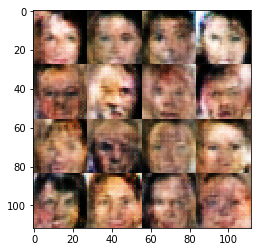

Epoch 2110/0... Discriminator Loss: 1.3175... Generator Loss: 0.8958
Epoch 2120/0... Discriminator Loss: 1.2465... Generator Loss: 1.0055
Epoch 2130/0... Discriminator Loss: 1.3211... Generator Loss: 0.7113
Epoch 2140/0... Discriminator Loss: 1.3750... Generator Loss: 0.7243
Epoch 2150/0... Discriminator Loss: 1.1926... Generator Loss: 0.7421
Epoch 2160/0... Discriminator Loss: 1.3500... Generator Loss: 0.5959
Epoch 2170/0... Discriminator Loss: 1.2578... Generator Loss: 0.8203
Epoch 2180/0... Discriminator Loss: 1.4232... Generator Loss: 0.6532
Epoch 2190/0... Discriminator Loss: 1.3726... Generator Loss: 0.7967
Epoch 2200/0... Discriminator Loss: 1.3263... Generator Loss: 0.9069


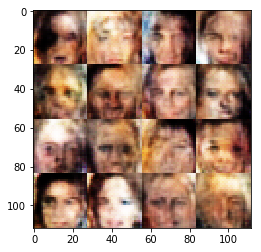

Epoch 2210/0... Discriminator Loss: 1.3689... Generator Loss: 0.7775
Epoch 2220/0... Discriminator Loss: 1.3319... Generator Loss: 0.7248
Epoch 2230/0... Discriminator Loss: 1.4757... Generator Loss: 0.6856
Epoch 2240/0... Discriminator Loss: 1.3029... Generator Loss: 0.8034
Epoch 2250/0... Discriminator Loss: 1.3768... Generator Loss: 0.7646
Epoch 2260/0... Discriminator Loss: 1.2392... Generator Loss: 0.8554
Epoch 2270/0... Discriminator Loss: 0.7877... Generator Loss: 2.3601
Epoch 2280/0... Discriminator Loss: 3.5166... Generator Loss: 0.5679
Epoch 2290/0... Discriminator Loss: 1.7252... Generator Loss: 0.6336
Epoch 2300/0... Discriminator Loss: 1.7384... Generator Loss: 0.8135


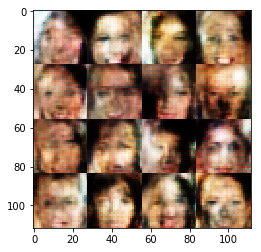

Epoch 2310/0... Discriminator Loss: 1.8500... Generator Loss: 0.5237
Epoch 2320/0... Discriminator Loss: 1.3996... Generator Loss: 0.5550
Epoch 2330/0... Discriminator Loss: 1.3596... Generator Loss: 0.7681
Epoch 2340/0... Discriminator Loss: 1.2796... Generator Loss: 0.8639
Epoch 2350/0... Discriminator Loss: 1.3121... Generator Loss: 0.7511
Epoch 2360/0... Discriminator Loss: 1.4399... Generator Loss: 0.7980
Epoch 2370/0... Discriminator Loss: 1.3979... Generator Loss: 0.8697
Epoch 2380/0... Discriminator Loss: 1.5303... Generator Loss: 0.6008
Epoch 2390/0... Discriminator Loss: 1.5039... Generator Loss: 0.5603
Epoch 2400/0... Discriminator Loss: 1.3739... Generator Loss: 0.6725


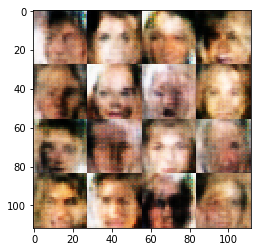

Epoch 2410/0... Discriminator Loss: 1.4888... Generator Loss: 0.7668
Epoch 2420/0... Discriminator Loss: 1.2402... Generator Loss: 0.7665
Epoch 2430/0... Discriminator Loss: 1.4696... Generator Loss: 0.9180
Epoch 2440/0... Discriminator Loss: 1.4129... Generator Loss: 0.6842
Epoch 2450/0... Discriminator Loss: 1.3216... Generator Loss: 0.9715
Epoch 2460/0... Discriminator Loss: 1.3394... Generator Loss: 0.8901
Epoch 2470/0... Discriminator Loss: 1.4689... Generator Loss: 0.6847
Epoch 2480/0... Discriminator Loss: 1.3934... Generator Loss: 0.7383
Epoch 2490/0... Discriminator Loss: 1.4158... Generator Loss: 0.7459
Epoch 2500/0... Discriminator Loss: 1.3778... Generator Loss: 0.6608


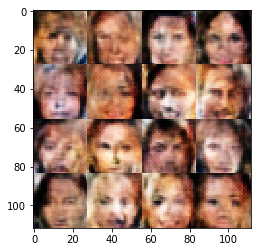

Epoch 2510/0... Discriminator Loss: 1.3025... Generator Loss: 0.8815
Epoch 2520/0... Discriminator Loss: 1.4428... Generator Loss: 0.6688
Epoch 2530/0... Discriminator Loss: 1.3205... Generator Loss: 0.7371
Epoch 2540/0... Discriminator Loss: 1.3614... Generator Loss: 0.8055
Epoch 2550/0... Discriminator Loss: 1.3540... Generator Loss: 0.8757
Epoch 2560/0... Discriminator Loss: 1.4027... Generator Loss: 0.8238
Epoch 2570/0... Discriminator Loss: 1.3417... Generator Loss: 0.8115
Epoch 2580/0... Discriminator Loss: 1.3590... Generator Loss: 0.9026
Epoch 2590/0... Discriminator Loss: 1.4475... Generator Loss: 0.7927
Epoch 2600/0... Discriminator Loss: 1.3702... Generator Loss: 0.8270


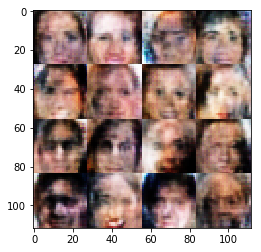

Epoch 2610/0... Discriminator Loss: 1.5371... Generator Loss: 0.6738
Epoch 2620/0... Discriminator Loss: 1.4226... Generator Loss: 0.8029
Epoch 2630/0... Discriminator Loss: 1.3112... Generator Loss: 0.6993
Epoch 2640/0... Discriminator Loss: 1.4482... Generator Loss: 0.7078
Epoch 2650/0... Discriminator Loss: 1.4277... Generator Loss: 0.7114
Epoch 2660/0... Discriminator Loss: 1.3699... Generator Loss: 0.7611
Epoch 2670/0... Discriminator Loss: 1.3683... Generator Loss: 0.8617
Epoch 2680/0... Discriminator Loss: 1.4310... Generator Loss: 0.7355
Epoch 2690/0... Discriminator Loss: 1.3578... Generator Loss: 0.6332
Epoch 2700/0... Discriminator Loss: 1.3458... Generator Loss: 0.7172


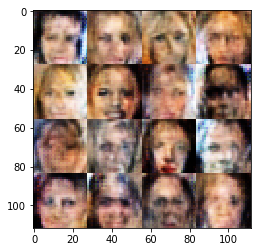

Epoch 2710/0... Discriminator Loss: 1.3816... Generator Loss: 0.7323
Epoch 2720/0... Discriminator Loss: 1.3819... Generator Loss: 0.7497
Epoch 2730/0... Discriminator Loss: 1.2993... Generator Loss: 0.7754
Epoch 2740/0... Discriminator Loss: 1.2758... Generator Loss: 0.8091
Epoch 2750/0... Discriminator Loss: 1.4283... Generator Loss: 0.5980
Epoch 2760/0... Discriminator Loss: 1.4227... Generator Loss: 0.7522
Epoch 2770/0... Discriminator Loss: 1.5581... Generator Loss: 0.6692
Epoch 2780/0... Discriminator Loss: 1.3586... Generator Loss: 0.7393
Epoch 2790/0... Discriminator Loss: 1.4987... Generator Loss: 0.8416
Epoch 2800/0... Discriminator Loss: 1.3800... Generator Loss: 0.7523


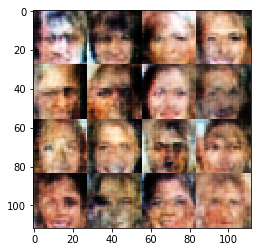

Epoch 2810/0... Discriminator Loss: 1.4395... Generator Loss: 0.7060
Epoch 2820/0... Discriminator Loss: 1.5307... Generator Loss: 0.5670
Epoch 2830/0... Discriminator Loss: 1.2453... Generator Loss: 1.0231
Epoch 2840/0... Discriminator Loss: 1.4322... Generator Loss: 1.4078
Epoch 2850/0... Discriminator Loss: 1.5165... Generator Loss: 0.9220
Epoch 2860/0... Discriminator Loss: 1.1981... Generator Loss: 0.9046
Epoch 2870/0... Discriminator Loss: 1.3781... Generator Loss: 0.9122
Epoch 2880/0... Discriminator Loss: 1.2611... Generator Loss: 0.9062
Epoch 2890/0... Discriminator Loss: 1.3691... Generator Loss: 0.8807
Epoch 2900/0... Discriminator Loss: 1.4891... Generator Loss: 0.5878


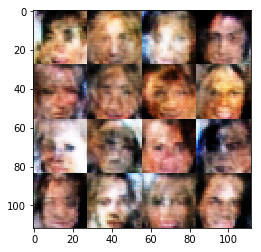

Epoch 2910/0... Discriminator Loss: 1.4235... Generator Loss: 0.6725
Epoch 2920/0... Discriminator Loss: 1.5224... Generator Loss: 0.7882
Epoch 2930/0... Discriminator Loss: 1.5396... Generator Loss: 0.7872
Epoch 2940/0... Discriminator Loss: 1.4161... Generator Loss: 0.7192
Epoch 2950/0... Discriminator Loss: 1.2307... Generator Loss: 1.0513
Epoch 2960/0... Discriminator Loss: 1.0221... Generator Loss: 1.4173
Epoch 2970/0... Discriminator Loss: 0.7169... Generator Loss: 2.3603
Epoch 2980/0... Discriminator Loss: 1.8871... Generator Loss: 1.0015
Epoch 2990/0... Discriminator Loss: 1.3372... Generator Loss: 0.6665
Epoch 3000/0... Discriminator Loss: 1.3704... Generator Loss: 0.8453


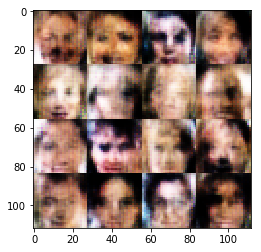

Epoch 3010/0... Discriminator Loss: 1.2144... Generator Loss: 0.9050
Epoch 3020/0... Discriminator Loss: 1.4493... Generator Loss: 0.5604
Epoch 3030/0... Discriminator Loss: 1.3745... Generator Loss: 0.7430
Epoch 3040/0... Discriminator Loss: 1.4371... Generator Loss: 0.6782
Epoch 3050/0... Discriminator Loss: 1.4410... Generator Loss: 0.6064
Epoch 3060/0... Discriminator Loss: 1.3631... Generator Loss: 0.9350
Epoch 3070/0... Discriminator Loss: 1.3064... Generator Loss: 0.7057
Epoch 3080/0... Discriminator Loss: 1.3520... Generator Loss: 0.7530
Epoch 3090/0... Discriminator Loss: 1.5520... Generator Loss: 0.6328
Epoch 3100/0... Discriminator Loss: 1.3315... Generator Loss: 0.7267


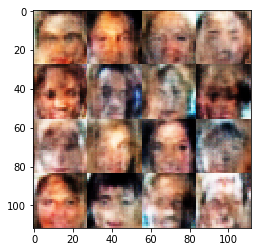

Epoch 3110/0... Discriminator Loss: 1.3952... Generator Loss: 0.7853
Epoch 3120/0... Discriminator Loss: 1.3908... Generator Loss: 0.7744
Epoch 3130/0... Discriminator Loss: 1.2535... Generator Loss: 0.8386
Epoch 3140/0... Discriminator Loss: 1.4093... Generator Loss: 0.7000
Epoch 3150/0... Discriminator Loss: 1.3763... Generator Loss: 0.8521
Epoch 3160/0... Discriminator Loss: 1.3068... Generator Loss: 0.7525
Epoch 3170/0... Discriminator Loss: 1.3114... Generator Loss: 0.7920
Epoch 3180/0... Discriminator Loss: 1.3897... Generator Loss: 0.7568
Epoch 3190/0... Discriminator Loss: 1.5181... Generator Loss: 0.6389
Epoch 3200/0... Discriminator Loss: 1.4614... Generator Loss: 0.8209


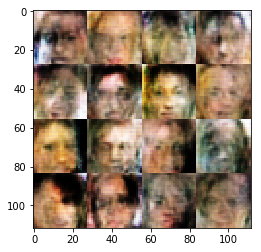

Epoch 3210/0... Discriminator Loss: 1.2631... Generator Loss: 0.8687
Epoch 3220/0... Discriminator Loss: 1.3525... Generator Loss: 0.8655
Epoch 3230/0... Discriminator Loss: 1.3321... Generator Loss: 0.8260
Epoch 3240/0... Discriminator Loss: 1.3297... Generator Loss: 0.6996
Epoch 3250/0... Discriminator Loss: 1.9951... Generator Loss: 0.5624
Epoch 3260/0... Discriminator Loss: 1.3442... Generator Loss: 0.7879
Epoch 3270/0... Discriminator Loss: 1.3460... Generator Loss: 0.7439
Epoch 3280/0... Discriminator Loss: 1.3817... Generator Loss: 0.7747
Epoch 3290/0... Discriminator Loss: 1.3279... Generator Loss: 0.7480
Epoch 3300/0... Discriminator Loss: 1.3386... Generator Loss: 0.7154


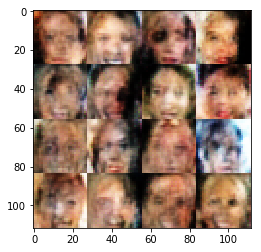

Epoch 3310/0... Discriminator Loss: 1.2259... Generator Loss: 0.7520
Epoch 3320/0... Discriminator Loss: 1.4270... Generator Loss: 0.9170
Epoch 3330/0... Discriminator Loss: 1.4643... Generator Loss: 0.6914
Epoch 3340/0... Discriminator Loss: 1.4897... Generator Loss: 0.8517
Epoch 3350/0... Discriminator Loss: 1.2971... Generator Loss: 0.8063
Epoch 3360/0... Discriminator Loss: 1.4100... Generator Loss: 0.9066
Epoch 3370/0... Discriminator Loss: 1.4967... Generator Loss: 0.5956
Epoch 3380/0... Discriminator Loss: 1.3466... Generator Loss: 0.8187
Epoch 3390/0... Discriminator Loss: 1.2572... Generator Loss: 0.7408
Epoch 3400/0... Discriminator Loss: 1.3695... Generator Loss: 0.7591


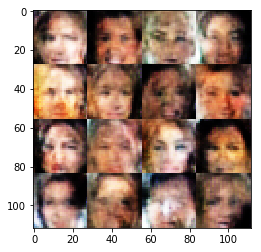

Epoch 3410/0... Discriminator Loss: 1.3165... Generator Loss: 0.6454
Epoch 3420/0... Discriminator Loss: 1.2396... Generator Loss: 0.8289
Epoch 3430/0... Discriminator Loss: 1.4930... Generator Loss: 0.6474
Epoch 3440/0... Discriminator Loss: 1.3818... Generator Loss: 0.9181
Epoch 3450/0... Discriminator Loss: 1.4410... Generator Loss: 0.7871
Epoch 3460/0... Discriminator Loss: 1.3168... Generator Loss: 0.8260
Epoch 3470/0... Discriminator Loss: 1.3211... Generator Loss: 1.0119
Epoch 3480/0... Discriminator Loss: 1.3526... Generator Loss: 0.6675
Epoch 3490/0... Discriminator Loss: 1.5499... Generator Loss: 0.6242
Epoch 3500/0... Discriminator Loss: 1.4596... Generator Loss: 0.6488


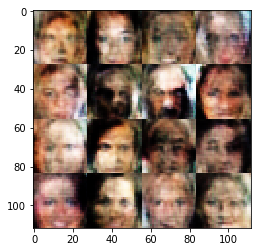

Epoch 3510/0... Discriminator Loss: 1.4001... Generator Loss: 0.7850
Epoch 3520/0... Discriminator Loss: 1.3417... Generator Loss: 0.6671
Epoch 3530/0... Discriminator Loss: 1.4277... Generator Loss: 0.6870
Epoch 3540/0... Discriminator Loss: 1.5470... Generator Loss: 0.6745
Epoch 3550/0... Discriminator Loss: 1.2717... Generator Loss: 0.9385
Epoch 3560/0... Discriminator Loss: 1.5384... Generator Loss: 0.7193
Epoch 3570/0... Discriminator Loss: 1.3728... Generator Loss: 0.7025
Epoch 3580/0... Discriminator Loss: 1.3740... Generator Loss: 0.8722
Epoch 3590/0... Discriminator Loss: 1.3964... Generator Loss: 0.7633
Epoch 3600/0... Discriminator Loss: 1.3520... Generator Loss: 0.9950


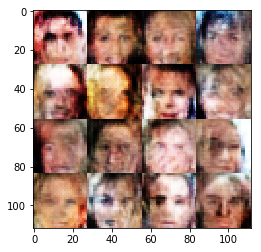

Epoch 3610/0... Discriminator Loss: 1.3240... Generator Loss: 0.8058
Epoch 3620/0... Discriminator Loss: 1.2694... Generator Loss: 0.6952
Epoch 3630/0... Discriminator Loss: 1.5495... Generator Loss: 0.7976
Epoch 3640/0... Discriminator Loss: 1.4550... Generator Loss: 0.6784
Epoch 3650/0... Discriminator Loss: 1.2634... Generator Loss: 0.9036
Epoch 3660/0... Discriminator Loss: 1.3649... Generator Loss: 0.8867
Epoch 3670/0... Discriminator Loss: 1.2452... Generator Loss: 0.8252
Epoch 3680/0... Discriminator Loss: 1.5287... Generator Loss: 0.6505
Epoch 3690/0... Discriminator Loss: 1.4714... Generator Loss: 0.8306
Epoch 3700/0... Discriminator Loss: 1.3136... Generator Loss: 0.8083


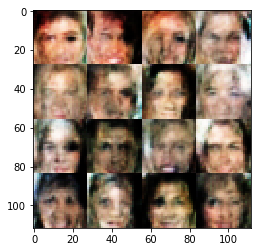

Epoch 3710/0... Discriminator Loss: 1.1833... Generator Loss: 0.9033
Epoch 3720/0... Discriminator Loss: 1.4059... Generator Loss: 0.8352
Epoch 3730/0... Discriminator Loss: 1.6074... Generator Loss: 0.7436
Epoch 3740/0... Discriminator Loss: 1.2864... Generator Loss: 0.8680
Epoch 3750/0... Discriminator Loss: 1.3661... Generator Loss: 0.7529
Epoch 3760/0... Discriminator Loss: 1.3889... Generator Loss: 0.6882
Epoch 3770/0... Discriminator Loss: 1.1848... Generator Loss: 0.8838
Epoch 3780/0... Discriminator Loss: 1.5077... Generator Loss: 0.6032
Epoch 3790/0... Discriminator Loss: 1.2965... Generator Loss: 0.8594
Epoch 3800/0... Discriminator Loss: 1.4209... Generator Loss: 0.6587


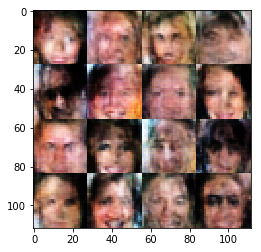

Epoch 3810/0... Discriminator Loss: 1.4055... Generator Loss: 0.6690
Epoch 3820/0... Discriminator Loss: 1.3786... Generator Loss: 0.7302
Epoch 3830/0... Discriminator Loss: 2.2658... Generator Loss: 0.6177
Epoch 3840/0... Discriminator Loss: 1.4320... Generator Loss: 0.7436
Epoch 3850/0... Discriminator Loss: 1.2437... Generator Loss: 0.8305
Epoch 3860/0... Discriminator Loss: 1.4769... Generator Loss: 0.8387
Epoch 3870/0... Discriminator Loss: 1.3601... Generator Loss: 0.6727
Epoch 3880/0... Discriminator Loss: 1.3882... Generator Loss: 0.6661
Epoch 3890/0... Discriminator Loss: 1.4017... Generator Loss: 1.0625
Epoch 3900/0... Discriminator Loss: 1.2775... Generator Loss: 0.8189


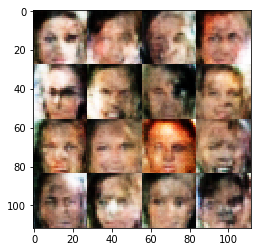

Epoch 3910/0... Discriminator Loss: 1.3031... Generator Loss: 0.9441
Epoch 3920/0... Discriminator Loss: 1.4203... Generator Loss: 0.5998
Epoch 3930/0... Discriminator Loss: 1.4002... Generator Loss: 0.7462
Epoch 3940/0... Discriminator Loss: 1.4464... Generator Loss: 0.9048
Epoch 3950/0... Discriminator Loss: 1.3562... Generator Loss: 1.1212
Epoch 3960/0... Discriminator Loss: 1.2680... Generator Loss: 1.0247
Epoch 3970/0... Discriminator Loss: 1.3131... Generator Loss: 0.7331
Epoch 3980/0... Discriminator Loss: 1.2593... Generator Loss: 0.9736
Epoch 3990/0... Discriminator Loss: 1.3903... Generator Loss: 0.7342
Epoch 4000/0... Discriminator Loss: 1.5060... Generator Loss: 0.6570


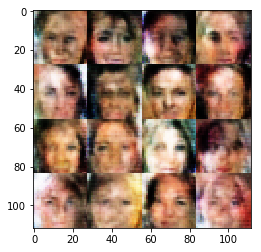

Epoch 4010/0... Discriminator Loss: 1.4111... Generator Loss: 0.8970
Epoch 4020/0... Discriminator Loss: 1.3621... Generator Loss: 0.8234
Epoch 4030/0... Discriminator Loss: 1.2048... Generator Loss: 0.9521
Epoch 4040/0... Discriminator Loss: 1.4301... Generator Loss: 0.9738
Epoch 4050/0... Discriminator Loss: 1.3789... Generator Loss: 0.7546
Epoch 4060/0... Discriminator Loss: 1.3758... Generator Loss: 0.8193
Epoch 4070/0... Discriminator Loss: 1.4100... Generator Loss: 0.6601
Epoch 4080/0... Discriminator Loss: 1.3617... Generator Loss: 0.9384
Epoch 4090/0... Discriminator Loss: 1.2699... Generator Loss: 0.7779
Epoch 4100/0... Discriminator Loss: 1.3104... Generator Loss: 0.8031


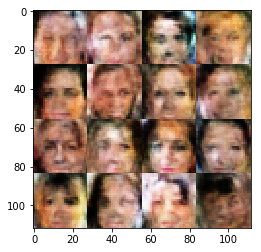

KeyboardInterrupt: 

In [13]:
batch_size = 16#None
z_dim =128 #None
learning_rate =0.001 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.